# Universe Builder

Just for fun :)

Largely inspired by:
- https://github.com/pmocz
- https://www.youtube.com/c/SciencephiletheAI

many thanks!

```
author:         Zach Wolpe
date:           05.09.22
```

In [2]:
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pylab as pl
import time

%matplotlib inline

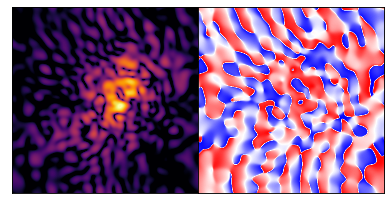

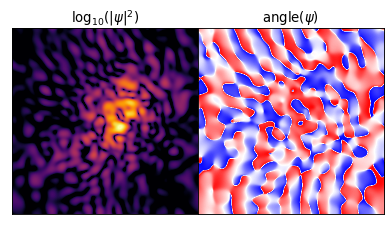

0

In [3]:
class Quantum_Simulation:
	def __init__(self) -> None:
		self.update_simulation_parameters()
		
	def update_simulation_parameters(self, N:int=512, t:int=0, tEnd:float=0.03, dt:float=0.0001, tOut:float=0.0001, G:float=4000, plotRealTime:bool=True) -> None:
		"""
		Simulation Parameters
			N:				spatial resolution
			t:				current time of the simulation
			tEnd:			time at which simulation ends
			dt:				timestep
			tOut:			draw frequency
			G:				gravitaitonal constant
			plotRealTime:	switch on for plotting as the simulation goes along	
		"""
		# configure parameters
		self.N				= N
		self.t				= t
		self.tEnd			= tEnd
		self.dt				= dt
		self.tOut			= tOut
		self.G				= G
		self.plotRealTime	= plotRealTime

		# Domain [0,1] x [0,1]
		self.L 				= 1    
		self.xlin 			= np.linspace(0,self.L, num=N+1)  		# Note: x=0 & x=1 are the same point!
		self.xlin 			= self.xlin[0:N]                     	# Chop off periodic point
		self.xx, self.yy 	= np.meshgrid(self.xlin, self.xlin)

	# update equations --------------------------------------------------------------------------------------++
	def execute_1_kick_1(self) -> None:
		"""(1/2) kick"""
		self.psi = np.exp(-1.j*self.dt/2.0*self.V) * self.psi
		
	def execute_2_drift(self) -> None:
		"""drift"""
		self.psihat = np.fft.fftn(self.psi)
		self.psihat = np.exp(self.dt * (-1.j*self.kSq/2.))  * self.psihat
		self.psi 	= np.fft.ifftn(self.psihat)

	def execute_3_update_potential(self) -> None:
		"""update potential"""
		self.Vhat 	= -np.fft.fftn(4.0*np.pi*self.G*(np.abs(self.psi)**2-1.0)) / (self.kSq  + (self.kSq==0))
		self.V 		= np.real(np.fft.ifftn(self.Vhat))

	def execute_4_kick_2(self) -> None:
		"""(1/2) kick"""
		self.psi = np.exp(-1.j*self.dt/2.0*self.V) * self.psi
	# update equations --------------------------------------------------------------------------------------++

	def compute_time_step(self, amp=0.01, sigma=0.03, rho=0.9) -> plt.figure:
		# Intial Condition
		self.amp 	= amp
		self.sigma 	= sigma
		self.rho	= rho

		# compute rho
		self.rho+= 2*amp*np.exp(-((self.xx-0.5)**2+(self.yy-0.5)**2)/2/sigma**2)/(sigma**3*np.sqrt(2*np.pi)**2)
		self.rho+= 1.5*amp*np.exp(-((self.xx-0.2)**2+(self.yy-0.7)**2)/2/sigma**2)/(sigma**3*np.sqrt(2*np.pi)**2)
		self.rho+= amp*np.exp(-((self.xx-0.4)**2+(self.yy-0.6)**2)/2/sigma**2)/(sigma**3*np.sqrt(2*np.pi)**2)
		self.rho+= amp*np.exp(-((self.xx-0.6)**2+(self.yy-0.8)**2)/2/sigma**2)/(sigma**3*np.sqrt(2*np.pi)**2)
		self.rho+= amp*np.exp(-((self.xx-0.8)**2+(self.yy-0.2)**2)/2/sigma**2)/(sigma**3*np.sqrt(2*np.pi)**2)
		self.rho+= amp*np.exp(-((self.xx-0.6)**2+(self.yy-0.7)**2)/2/sigma**2)/(sigma**3*np.sqrt(2*np.pi)**2)
		self.rho+= amp*np.exp(-((self.xx-0.7)**2+(self.yy-0.4)**2)/2/sigma**2)/(sigma**3*np.sqrt(2*np.pi)**2)
		self.rho+= amp*np.exp(-((self.xx-0.3)**2+(self.yy-0.3)**2)/2/sigma**2)/(sigma**3*np.sqrt(2*np.pi)**2)

	
		# normalize wavefunction to <|psi|^2>=1
		self.rhobar 		= np.mean(self.rho)
		self.rho 			/= self.rhobar
		self.psi 			= np.sqrt(self.rho)
	
		# Fourier Space Variables
		self.klin			= 2.0 * np.pi / self.L * np.arange(-self.N/2, self.N/2)
		self.kx, self.ky 	= np.meshgrid(self.klin, self.klin)
		self.kx 			= np.fft.ifftshift(self.kx)
		self.ky 			= np.fft.ifftshift(self.ky)
		self.kSq 			= self.kx**2 + self.ky**2
	
		# Potential
		self.Vhat 			= -np.fft.fftn(4.0*np.pi*self.G*(np.abs(self.psi)**2-1.0)) / (self.kSq  + (self.kSq==0))
		self.V				= np.real(np.fft.ifftn(self.Vhat))
		
		# number of timesteps
		self.Nt		 		= int(np.ceil(self.tEnd/self.dt))
	
		# prep figure
		fig 				= pl.figure(figsize=(6,4), dpi=80)
		grid 				= pl.GridSpec(1, 2, wspace=0.0, hspace=0.0)
		ax1 				= pl.subplot(grid[0,0])
		ax2 				= pl.subplot(grid[0,1])
		outputCount 		= 1



		# Simulation Main Loop
		for i in range(self.Nt):

			self.execute_1_kick_1()
			self.execute_2_drift()
			self.execute_3_update_potential()
			self.execute_4_kick_2()
			
			# update time
			self.t += self.dt

			# Plot --------------------------------------------------------------------------------------++
			plotThisTurn = False
			if self.t + self.dt > outputCount*self.tOut:
				plotThisTurn = True
			if (self.plotRealTime and plotThisTurn) or (i == self.Nt-1):
				
				pl.sca(ax1)
				pl.cla()
				
				pl.imshow(np.log10(np.abs(self.psi)**2), cmap = 'inferno')
				pl.clim(-1, 2)
				ax1.get_xaxis().set_visible(False)
				ax1.get_yaxis().set_visible(False)	
				ax1.set_aspect('equal')	
				
				pl.sca(ax2)
				pl.cla()
				pl.imshow(np.angle(self.psi), cmap = 'bwr')
				pl.clim(-np.pi, np.pi)
				ax2.get_xaxis().set_visible(False)
				ax2.get_yaxis().set_visible(False)	
				ax2.set_aspect('equal')	
				
				# pl.pause(0.001)
				time.sleep(0.2)
				display.clear_output(wait=True)
				display.display(pl.gcf())
				outputCount += 1
			# Plot --------------------------------------------------------------------------------------++
				

				
		# Save plot -------------------------------------------------------------------------------------++
		pl.sca(ax1)
		pl.title(r'$\log_{10}(|\psi|^2)$')
		pl.sca(ax2)
		pl.title(r'${\rm angle}(\psi)$')
		pl.savefig('quantumspectral.png',dpi=240)
		pl.show()
		return 0
		# Save plot -------------------------------------------------------------------------------------++


qa = Quantum_Simulation()
qa.update_simulation_parameters()
qa.compute_time_step()